### Supervisor Agent maintaining two Agents: One is Finance Agent and Other is Web search agent.

In [1]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [5]:
!pip3 install ddgs

In [6]:
# Web search Tool
from langchain_community.tools import DuckDuckGoSearchRun

ddg_tool = DuckDuckGoSearchRun()
ddg_tool.invoke("What is the capital of France?")

/Users/I572648/Library/CloudStorage/OneDrive-SAPSE/Desktop/Git/GenAI/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'Jun 29, 2025 · Paris, the capital of France, is located in the north-central portion of the country. It constitutes one of the départements of the Île-de-France administrative region and is France\'s … 1 day ago · Paris is the capital of France (French Republic), situated in the Western Europe subregion of Europe. In Paris, the currency used is Euro (€), which is the official currency used … Nov 26, 2024 · Answer: Explanation: The capital of France is Paris, and there are no other official capitals. However, there are several other major cities in France that are important, such as: … May 30, 2025 · DO YOU KNOW WHAT IS THE CAPITAL OF FRANCE? World-famous for its art, fashion, food, and history. Learn everything about Paris, the capital city of France, and why it\'s called the "City of... May 4, 2025 · So France’s capital would logically be a major city. Paris seems to fit here. But just to make sure, maybe there’s a common misconception. For example, someone might confuse …'

In [103]:
import yfinance as yf
from langchain.tools import tool
from typing import TypedDict

@tool
def get_stock_price(ticker: str) -> str:
    """Gets the current stock price of a given ticker symbol."""
    print(f"Fetching stock price for ticker: {ticker}")
    try: 
        stock = yf.Ticker(ticker)
        price = stock.info.get("previousClose")
        if price is None:
            return f"Could not fetch price for ticker {ticker}."
        return f"The last closing price of {ticker} is ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching the stock price: {str(e)}"

get_stock_price.invoke("AAPL")

Fetching stock price for ticker: AAPL


'The last closing price of AAPL is $212.41.'

In [9]:
finance_tools = [get_stock_price, ddg_tool]

In [10]:
llm_with_finance_tools = llm.bind_tools(finance_tools)

In [122]:
# memory 
memory = MemorySaver()

In [104]:
from langgraph.graph import MessagesState

SYSTEM_PROMPT = "You are a helpful assistant tasked with using yahoo finance tools to answer user questions about stock prices."
def llm_with_finance_call(state: MessagesState):
    print("=======Finance App===========")
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_finance_tools.invoke(input_question)
    return {"messages":[response]}

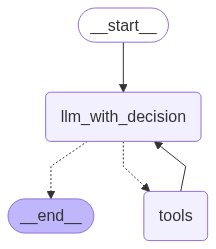

In [132]:
# Create a langGraph LLM with tools
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# memory = MemorySaver()
builder = StateGraph(MessagesState)
builder.add_node("llm_with_decision", llm_with_finance_call)
builder.add_node("tools", ToolNode(finance_tools))
builder.add_edge(START, "llm_with_decision")
builder.add_conditional_edges("llm_with_decision", tools_condition)
builder.add_edge("tools", "llm_with_decision")
builder.add_edge("llm_with_decision", END)
finance_app = builder.compile(checkpointer=True)
finance_app

In [ ]:
finance_app.invoke({"messages": "Get the stock price of APPLE"})

In [21]:
from langchain_community.tools import YouTubeSearchTool

youtube_tool = YouTubeSearchTool()

print(youtube_tool.name)
print(youtube_tool.description)

youtube_search
search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional


In [22]:
video_tools = [youtube_tool]

In [23]:
llm_with_youtube_tools = llm.bind_tools(video_tools)

In [24]:
from langgraph.graph import MessagesState

SYSTEM_PROMPT = "You are a helpful assistant tasked with getting the latest YouTube videos based on user queries."
def llm_with_youtube_call(state: MessagesState):
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_youtube_tools.invoke(input_question)
    return {"messages":[response]}

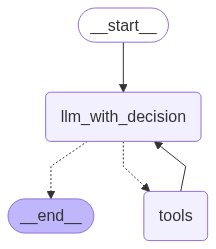

In [133]:
# Create a langGraph LLM with tools
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# memory = MemorySaver()
builder = StateGraph(MessagesState)
builder.add_node("llm_with_decision", llm_with_youtube_call)
builder.add_node("tools", ToolNode(video_tools))
builder.add_edge(START, "llm_with_decision")
builder.add_conditional_edges("llm_with_decision", tools_condition)
builder.add_edge("tools", "llm_with_decision")
builder.add_edge("llm_with_decision", END)
video_app = builder.compile(checkpointer=True)
video_app

In [28]:
members = ["finance app", "video app"]

In [137]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Always Use the memory for the conversation.
When finished, respond with FINISH.
"""

In [42]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.types import Command

In [43]:
class Router(TypedDict):
    next: Literal['finance_app', 'video_app', 'FINISH']

In [138]:

def supervisor_agent(state:MessagesState)->Command[Literal['finance_app', 'video_app', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})


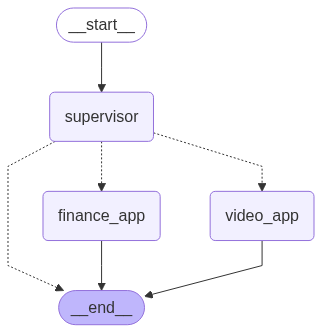

In [139]:
#supervisor 

workflow = StateGraph(MessagesState)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("finance_app", finance_app)
workflow.add_node("video_app", video_app)
workflow.add_edge(START, "supervisor")
supervisor_app = workflow.compile(checkpointer=memory)
supervisor_app

In [183]:
config={"configurable": {"thread_id": "3"}}
supervisor_app.invoke({"messages": [{"role": "user", "content": "what is the stock price of last two companies I have mentioned"}]}, config=config)

**********BELOW IS MY GOTO***************
finance_app
=======Finance App===========


{'messages': [HumanMessage(content='what is the last closing price of AAPL ', additional_kwargs={}, response_metadata={}, id='680bb96e-fd90-48ec-b650-e0aeaf74081b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s3kM7C9kWaS8gAi94OxwB0oy', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 132, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bs96Ap8b92bbEoIR8RWadtScl4OTf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--87838c89-f71a-4218-b390-5525494a7bff-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAP

In [151]:
config={"configurable": {"thread_id": "1"}}
for s in supervisor_app.stream({"messages": [("user", "what is the stcok price of APPLE")]}, subgraphs=True, config=config):
    print(s)

**********BELOW IS MY GOTO***************
finance_app
((), {'supervisor': None})
=======Finance App===========
(('finance_app',), {'llm_with_decision': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BI6orlk8wtIj8NsbAJUlRzhv', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1514, 'total_tokens': 1530, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bs8uRqiUYunZK4xK6zPtqDPqI0Oap', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9456c78-8259-44ce-8a26-ca090fc4bc02-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': '

In [148]:
message = [HumanMessage(content = "What is the stock price of GOOGLE ?")]
for event in supervisor_app.stream({"messages": message}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the stock price of GOOGLE ?
**********BELOW IS MY GOTO***************
finance_app
=======Finance App===========
=======Finance App===========
================================== Ai Message ==================================

The last closing price of Google's stock (GOOGL) is $177.62.


In [142]:
message = [HumanMessage(content = "can you provide videos on langgraph?")]
for event in supervisor_app.stream({"messages": message}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you provide videos on langgraph?
**********BELOW IS MY GOTO***************
video_app
================================== Ai Message ==================================

Here are some YouTube videos on Langgraph:

1. [Video 1](https://www.youtube.com/watch?v=jGg_1h0qzaM&pp=ygUJTGFuZ2dyYXBo)
2. [Video 2](https://www.youtube.com/watch?v=CnXdddeZ4tQ&pp=ygUJTGFuZ2dyYXBo)


In [144]:
message = [HumanMessage(content = "can you provide videos on langgraph?")]
for event in supervisor_app.stream({"messages": message}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you provide videos on langgraph?
**********BELOW IS MY GOTO***************
video_app
================================== Ai Message ==================================

Here are some YouTube videos on Langgraph:

1. [Langgraph Video 1](https://www.youtube.com/watch?v=CnXdddeZ4tQ&pp=ygUJTGFuZ2dyYXBo)
2. [Langgraph Video 2](https://www.youtube.com/watch?v=jGg_1h0qzaM&pp=ygUJTGFuZ2dyYXBo)


In [184]:
memory.get(config=config)

{'v': 3,
 'ts': '2025-07-11T14:36:25.680890+00:00',
 'id': '1f05e646-c656-6028-8021-5bb27313e7f7',
 'channel_versions': {'__start__': '00000000000000000000000000000033.0.9048217029851195',
  'messages': '00000000000000000000000000000035.0.44716613528803006',
  'branch:to:supervisor': '00000000000000000000000000000034.0.650682182148515',
  'branch:to:finance_app': '00000000000000000000000000000035.0.5498329661399651'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000032.0.4039465597028985'},
  'supervisor': {'branch:to:supervisor': '00000000000000000000000000000033.0.6339437656869115'},
  'finance_app': {'branch:to:finance_app': '00000000000000000000000000000034.0.421539907016511'}},
 'pending_sends': [],
 'channel_values': {'messages': [HumanMessage(content='what is the last closing price of AAPL ', additional_kwargs={}, response_metadata={}, id='680bb96e-fd90-48ec-b650-e0aeaf74081b'),
   AIMessage(content='', additional_kwargs={'tool_call